### Treniranje modela YOLOv8n

U ovoj bilježnici treniran je model YOLOv8n.pt, ali uz drugačiji izbor parametara i optimizatora.

In [ ]:
from ultralytics import YOLO
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [2]:
#model = YOLO('yolov8n.pt') 
model = YOLO('C:/Users/Ivona/Desktop/Codeasy/runs/detect/train38/weights/best.pt')

Nakon učitavanja YOLOv8.pt, nastavljeno je treniranje modela spremljenog kao best.pt u odgovarajući folder. Logovi ovih treniranja spremljeni su u train10, train15, train25 i train38. Folderi s neuspješnim treniranjima (primjerice zbog "Python Kernel died") nisu sadržavali nikakve datoteke pa su naknadno izbrisani iz direktorija detect. Za optimizator izabran je SGD, batch size je 32, budući da je dosadašnje treniranje nano modela pokazalo lošije učenje na malim batchevima. Stopa učenja postavljena je na 0.001, što je rezultiralo nešto dužim treniranjem ali stabilnim rezultatima. Prva dva treniranja provedena su u 10 epoha, a zatim je broj epoha povećan na 30. 

In [ ]:
results = model.train(data='config.yaml', batch=32, optimizer='SGD', lr0=0.001, imgsz=640, epochs=30)

In [ ]:
metrics = model.val()

In [8]:
print("Metrike na skupu za validaciju")
print("mAP50-95: ", metrics.box.map)
print("mAP50: ", metrics.box.map50)
print("mAP75: ",metrics.box.map75)
print("mAP50-95 za klasu Sheep: ", metrics.box.maps[0])
print("mAP50-95 za klasu Owl: ", metrics.box.maps[1]) 

Metrike na skupu za validaciju
mAP50-95:  0.5009050832199206
mAP50:  0.5757580564321977
mAP75:  0.5439994794446524
mAP50-95 za klasu Sheep:  0.6439466129034079
mAP50-95 za klasu Owl:  0.35786355353643323


Predviđanje na skupu za testiranje

Uzet je proizvoljni manji podskup skupa za testiranje za provjeru rezultata.

In [19]:
folder_path = 'C:/Users/Ivona/Desktop/Codeasy/yolo_test_dataset/'
image_names =['e4c10a917982174f.jpg', '2bc6fded1a1ff77f.jpg', 'f4fd263742e8f5fd.jpg', '2e1ee30bd03852fe.jpg']
for name in image_names:
    image_path=folder_path+name
    results=model(image_path, conf=0.15, imgsz=640, show=True, show_labels=True, show_conf=True, show_boxes=True)


image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\e4c10a917982174f.jpg: 448x640 1 Owl, 138.8ms
Speed: 6.8ms preprocess, 138.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\2bc6fded1a1ff77f.jpg: 448x640 1 Owl, 217.8ms
Speed: 14.9ms preprocess, 217.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\f4fd263742e8f5fd.jpg: 448x640 (no detections), 231.3ms
Speed: 3.1ms preprocess, 231.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\2e1ee30bd03852fe.jpg: 448x640 (no detections), 288.4ms
Speed: 10.1ms preprocess, 288.4ms inference, 12.8ms postprocess per image at shape (1, 3, 448, 640)


Ovako dotreniran model ne radi dovoljno dobro, kod slika ovaca ne uspijeva napraviti detekciju.

In [3]:
results=model('C:/Users/Ivona/Desktop/Codeasy/yolo_test_dataset/2bc6fded1a1ff77f.jpg', conf=0.15, imgsz=640, show=True, show_labels=True, show_conf=True, show_boxes=True)


image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\2bc6fded1a1ff77f.jpg: 448x640 1 Owl, 121.7ms
Speed: 3.5ms preprocess, 121.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Rezultati detekcije za sliku sove:

In [ ]:
for r in results:
    print(r.boxes)

In [ ]:
for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    im.show()
    im.save('results3.jpg')

### Vizualizacija točnosti tijekom treniranja

In [3]:
t = ['train10', 'train15', 'train25', 'train38']
p = 'C:/Users/Ivona/Desktop/Codeasy/runs/detect/'
dfs = []
for tr in t:
    putanja = p + str(tr) + '/results.csv'
    df = pd.read_csv(putanja)
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)

In [4]:
precision_metrics = ['   metrics/precision(B)', '       metrics/mAP50(B)', '    metrics/mAP50-95(B)']
loss_functions = ['           val/box_loss', '           val/cls_loss', '           val/dfl_loss']

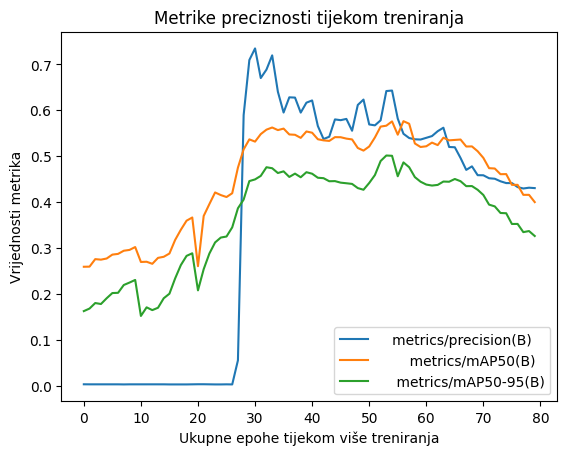

In [5]:
for pm in precision_metrics:
    plt.plot(merged_df[pm], label=pm)
plt.legend()
plt.title('Metrike preciznosti tijekom treniranja')
plt.xlabel('Ukupne epohe tijekom više treniranja')
plt.ylabel('Vrijednosti metrika')
plt.show()

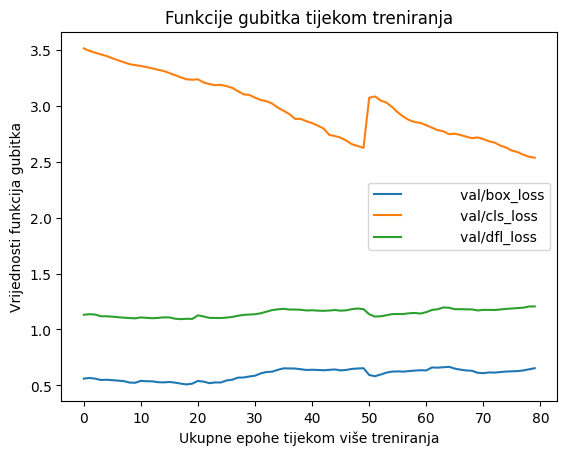

In [6]:
for lf in loss_functions:
    plt.plot(merged_df[lf], label=lf)
plt.legend()
plt.title('Funkcije gubitka tijekom treniranja')
plt.xlabel('Ukupne epohe tijekom više treniranja')
plt.ylabel('Vrijednosti funkcija gubitka')
plt.show()

U usporedbi s prethodnim dotreniranim modelom iz train20, ovaj model ima nešto lošije performanse i veći iznos funkcije gubitka. Prilikom validacije, postignuta je preciznost detektiranja bounding boxes od 64%, tj. 86% za slike ovaca i 41% za slike sova. Metrike preciznosti također pokazuju niže vrijednosti: mAP50 ima vrijednost 57%, za slike ovaca 73%, a za slike sova 42%. Metrika mAP50-95 ima iznos 50% ukupno, za slike ovaca  64%, a za slike sova 35%. Ukupna sposobnost detektiranja neke klase je 62%, dok je odziv (recall) za slike ovaca 58%, a za slike sova 66%.

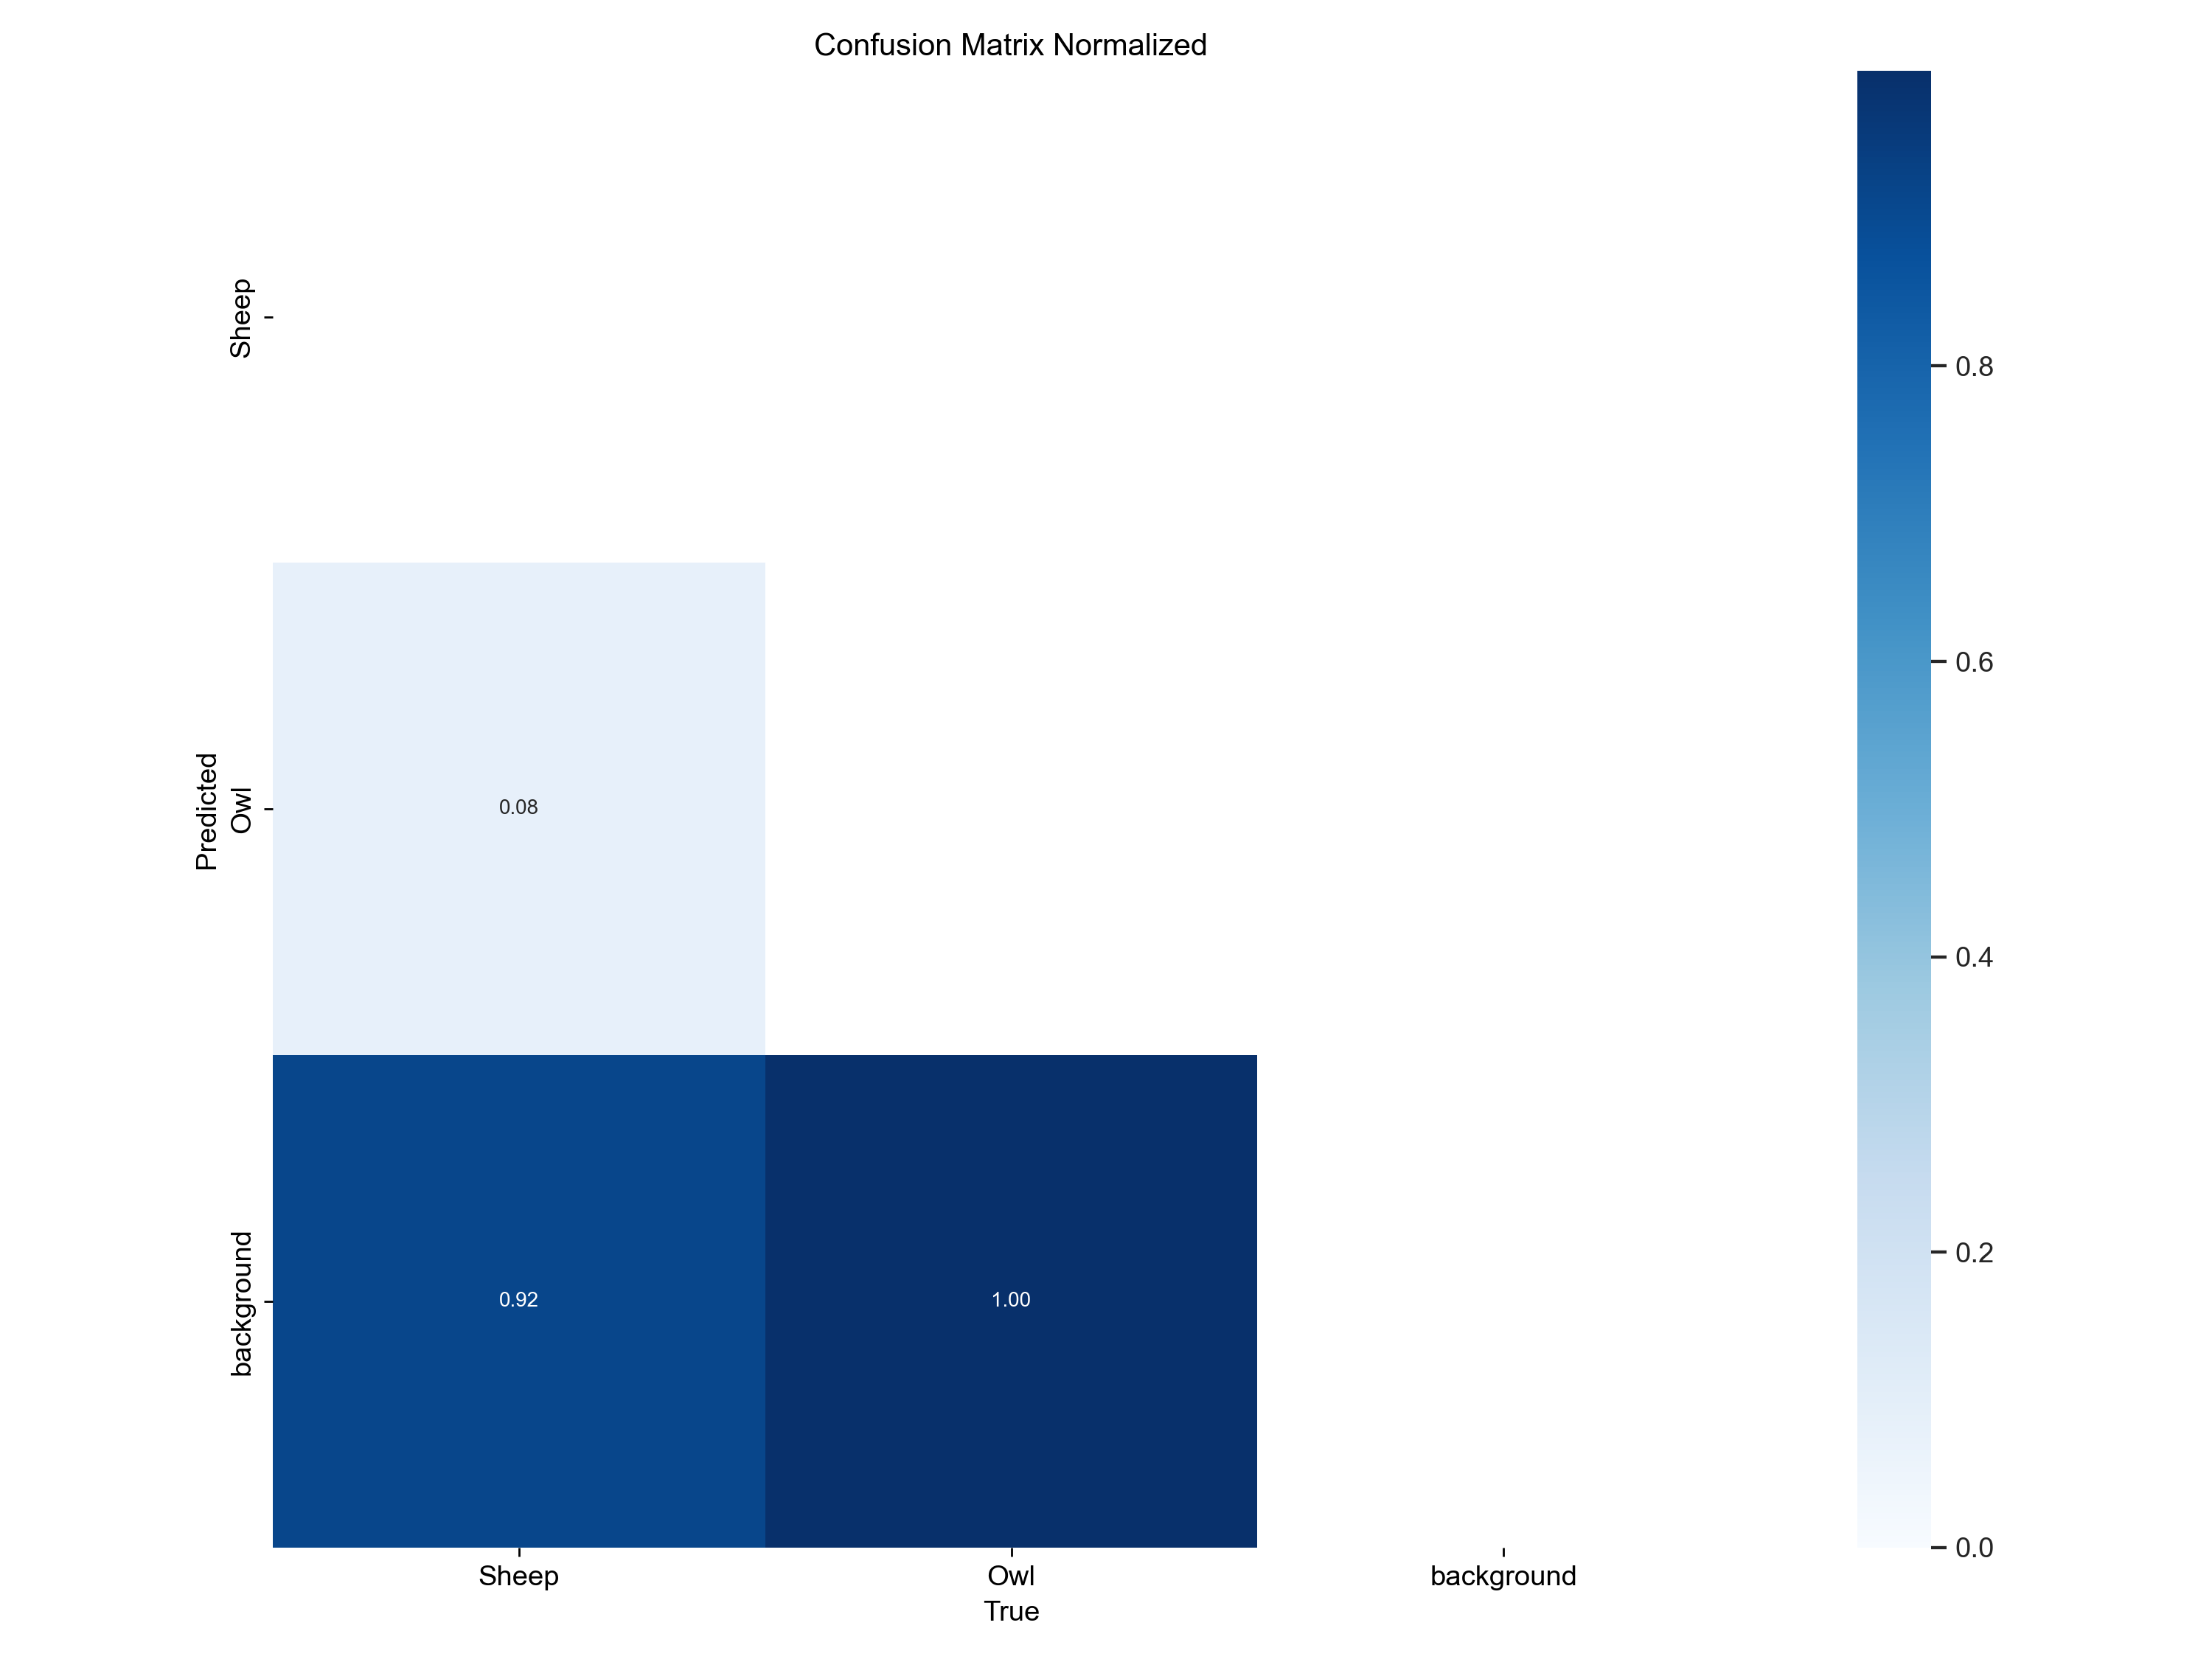

In [7]:
matrix_path = 'C:/Users/Ivona/Desktop/Codeasy/runs/detect/train38/confusion_matrix_normalized.png'
display(Image(filename=matrix_path, width=800, height=800))

Matrica konfuzije potvrđuje slabije rezultate, model ne uspijeva prepoznati ovce i sove, nego ih uglavnom detektira kao pozadinu.